Link to the original blog post: https://jina-ai-gmbh.ghost.io/using-jina-reranker-with-haystack-2.0-pipelines-to-retrieve-jira-support-tickets

# Jina Haystack extension

Install prerequisites:

In [13]:
!pip install --quiet haystack-ai jina-haystack chroma-haystack

Add the Jina API key as environment variable:

In [2]:
import os

os.environ['JINA_API_KEY']  = '<Jina API key>'

Create the vector store:

In [3]:
from haystack_integrations.document_stores.chroma import ChromaDocumentStore

document_store = ChromaDocumentStore()

Define the custom cleaner to remove irrelevant data:

In [4]:
import json
from typing import List
from haystack import Document, component

relevant_keys = ['Summary', 'Issue key', 'Issue id', 'Parent id', 'Issue type', 'Status', 'Project lead', 'Priority', 'Assignee', 'Reporter', 'Creator', 'Created', 'Updated', 'Last Viewed', 'Due Date', 'Labels',
                 'Description', 'Comment', 'Comment__1', 'Comment__2', 'Comment__3', 'Comment__4', 'Comment__5', 'Comment__6', 'Comment__7', 'Comment__8', 'Comment__9', 'Comment__10', 'Comment__11', 'Comment__12',
                 'Comment__13', 'Comment__14', 'Comment__15']

@component
class RemoveKeys:
    @component.output_types(documents=List[Document])
    def run(self, file_name: str):
        with open(file_name, 'r') as file:
            tickets = json.load(file)
        cleaned_tickets = []
        for t in tickets:
            t = {k: v for k, v in t.items() if k in relevant_keys and v}
            cleaned_tickets.append(t)
        return {'documents': cleaned_tickets}

Define the custom JSON converter:

In [5]:
@component
class JsonConverter:
    @component.output_types(documents=List[Document])
    def run(self, tickets: List[Document]):
        tickets_documents = []
        for t in tickets:
            if 'Parent id' in t:
                t = Document(content=json.dumps(t), meta={'Issue key': t['Issue key'], 'Issue id': t['Issue id'], 'Parent id': t['Parent id']})
            else:
                t = Document(content=json.dumps(t), meta={'Issue key': t['Issue key'], 'Issue id': t['Issue id'], 'Parent id': ''})
            tickets_documents.append(t)
        return {'documents': tickets_documents}

Create and run the indexing pipeline:

In [6]:
from haystack import Pipeline

from haystack.components.writers import DocumentWriter
from haystack_integrations.components.retrievers.chroma import ChromaEmbeddingRetriever
from haystack.document_stores.types import DuplicatePolicy

from haystack_integrations.components.embedders.jina import JinaDocumentEmbedder

retriever = ChromaEmbeddingRetriever(document_store=document_store)
retriever_reranker = ChromaEmbeddingRetriever(document_store=document_store)

indexing_pipeline = Pipeline()
indexing_pipeline.add_component('cleaner', RemoveKeys())
indexing_pipeline.add_component('converter', JsonConverter())
indexing_pipeline.add_component('embedder', JinaDocumentEmbedder(model='jina-embeddings-v2-base-en'))
indexing_pipeline.add_component('writer', DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP))

indexing_pipeline.connect('cleaner', 'converter')
indexing_pipeline.connect('converter', 'embedder')
indexing_pipeline.connect('embedder', 'writer')

indexing_pipeline.run({'cleaner': {'file_name': 'tickets.json'}})

Calculating embeddings: 100%|█████████████████████| 1/1 [00:03<00:00,  3.94s/it]


{'embedder': {'meta': {'model': 'jina-embeddings-v2-base-en',
   'usage': {'total_tokens': 21102, 'prompt_tokens': 21102}}},
 'writer': {'documents_written': 31}}

Define the custom cleaner to remove related tickets:

In [7]:
from typing import Optional

@component
class RemoveRelated:
    @component.output_types(documents=List[Document])
    def run(self, tickets: List[Document], query_id: Optional[str]):
        retrieved_tickets = []
        for t in tickets:
            if not t.meta['Issue id'] == query_id and not t.meta['Parent id'] == query_id:
                retrieved_tickets.append(t)
        return {'documents': retrieved_tickets}

Create the query pipeline WITHOUT Jina Reranker to compare the results prior to the reranking:

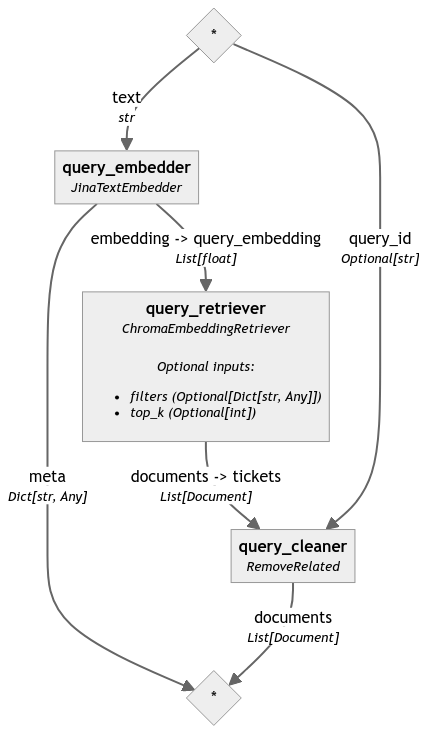

In [8]:
from haystack_integrations.components.embedders.jina import JinaTextEmbedder
from haystack_integrations.components.rankers.jina import JinaRanker

query_pipeline = Pipeline()
query_pipeline.add_component('query_embedder', JinaTextEmbedder(model='jina-embeddings-v2-base-en'))
query_pipeline.add_component('query_retriever', retriever)
query_pipeline.add_component('query_cleaner', RemoveRelated())

query_pipeline.connect('query_embedder.embedding', 'query_retriever.query_embedding')
query_pipeline.connect('query_retriever', 'query_cleaner')

Create the query pipeline WITH Jina Reranker to compare the results after the reranking:

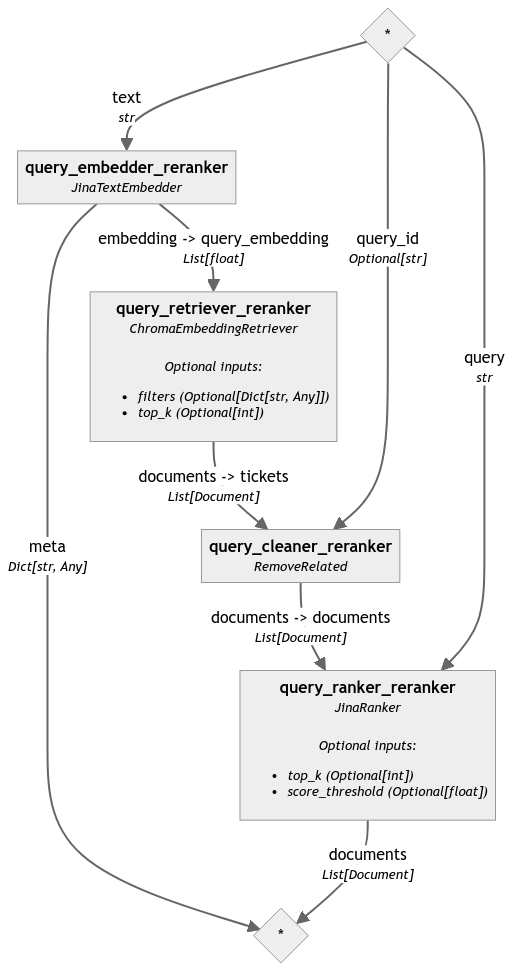

In [9]:
query_pipeline_reranker = Pipeline()
query_pipeline_reranker.add_component('query_embedder_reranker', JinaTextEmbedder(model='jina-embeddings-v2-base-en'))
query_pipeline_reranker.add_component('query_retriever_reranker', retriever_reranker)
query_pipeline_reranker.add_component('query_cleaner_reranker', RemoveRelated())
query_pipeline_reranker.add_component('query_ranker_reranker', JinaRanker())

query_pipeline_reranker.connect('query_embedder_reranker.embedding', 'query_retriever_reranker.query_embedding')
query_pipeline_reranker.connect('query_retriever_reranker', 'query_cleaner_reranker')
query_pipeline_reranker.connect('query_cleaner_reranker', 'query_ranker_reranker')

Define the query as a ticket in the dataset that needs to be compared:

In [10]:
query_ticket_key = 'ZOOKEEPER-3282'

with open('tickets.json', 'r') as file:
    tickets = json.load(file)

for ticket in tickets:
    if ticket['Issue key'] == query_ticket_key:
        query = str(ticket)
        query_ticket_id = ticket['Issue id']

Run the query pipeline WITHOUT Jina Reranker:

In [11]:
result = query_pipeline.run(data={'query_embedder':{'text': query},
                                  'query_retriever': {'top_k': 20},
                                  'query_cleaner': {'query_id': query_ticket_id}
                                  }
                            )

for idx, res in enumerate(result['query_cleaner']['documents']):
    print('Doc {}:'.format(idx + 1), res)

Doc 1: Document(id=a7c66ceed25d60f02ccfc89ccc549a5171930df088bacff0397b7b4c06f6c0b4, content: '{"Summary": "Errors that happen during sync() processing at the leader do not get propagated back to...', meta: {'Issue id': 12478629, 'Issue key': 'ZOOKEEPER-915', 'Parent id': ''}, score: 22.912071228027344, embedding: vector of size 768)
Doc 2: Document(id=7b34b3bdfd1922b9f5ccf58c9ac7b93ef2c8d1f3326db0f6858d1b61635ce0ff, content: '{"Summary": "Append to zookeeper.out (not overwrite) to support logrotation", "Issue key": "ZOOKEEPE...', meta: {'Issue id': 12728973, 'Issue key': 'ZOOKEEPER-1983', 'Parent id': ''}, score: 28.89113998413086, embedding: vector of size 768)
Doc 3: Document(id=b42ea1eaccf11d92a3ede114f0ebbf65bc34f9a87ad5b5bf25c49a3a562277d4, content: '{"Summary": "fix the build warnings about @see,@link,@return found by IDEA", "Issue key": "ZOOKEEPER...', meta: {'Issue id': 13297249, 'Issue key': 'ZOOKEEPER-3789', 'Parent id': ''}, score: 31.822677612304688, embedding: vector of s

Run the query pipeline WITH Jina Reranker:

In [12]:
result = query_pipeline_reranker.run(data={'query_embedder_reranker':{'text': query},
                                  'query_retriever_reranker': {'top_k': 20},
                                  'query_cleaner_reranker': {'query_id': query_ticket_id},
                                  'query_ranker_reranker': {'query': query, 'top_k': 10}
                                  }
                            )

for idx, res in enumerate(result['query_ranker_reranker']['documents']):
    print('Doc {}:'.format(idx + 1), res)

Doc 1: Document(id=1dbad7df6c4469887277c725df90acd1b74808ddd14e74fc2dcb810c01173cce, content: '{"Summary": "Add a documentation about docker", "Issue key": "ZOOKEEPER-3587", "Issue id": 13262989,...', meta: {'Issue id': 13262989, 'Issue key': 'ZOOKEEPER-3587', 'Parent id': ''}, score: 0.8118252158164978, embedding: vector of size 768)
Doc 2: Document(id=9b409e502405984ff89faad48614c42b42e7b9feed6f558c547b4ef416f5974d, content: '{"Summary": "support the complete linearizable read and multiply read consistency level", "Issue key...', meta: {'Issue id': 13265507, 'Issue key': 'ZOOKEEPER-3600', 'Parent id': ''}, score: 0.8094266653060913, embedding: vector of size 768)
Doc 3: Document(id=e54c6e704e42ad8f12b995c3a4d8f412bf89c03df54922a70368f86327da9d3f, content: '{"Summary": "[admin server way] Add a complete backup mechanism for zookeeper internal", "Issue key"...', meta: {'Issue id': 13249579, 'Issue key': 'ZOOKEEPER-3499', 'Parent id': ''}, score: 0.8083699941635132, embedding: vector of